#  **INSTALLING THE NECESSARY PACKAGES**

In [1]:
pip install pandas scikit-learn torch torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.8 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


# **IMPORTING THE PACKAGES**

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch_geometric.data import Data
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.nn import GCNConv
from torch.optim import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.tensorboard import SummaryWriter
from wordcloud import WordCloud 

2024-08-02 16:40:00.800333: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-02 16:40:00.800448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-02 16:40:00.932942: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Checking Cuda is present or not 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


# **LOADING THE DATASET**

In [4]:
# Load the datasets
imdb_data = pd.read_csv('/kaggle/input/gnn-dataset/IMDB_Dataset.csv')
twitter_data = pd.read_csv('/kaggle/input/gnn-dataset/Twitter_Data.csv')
twitter_data = twitter_data.dropna(subset=['clean_text'])

#  **Sample of the loaded dataset**

In [5]:
# Display a sample
print("Sample of the IMDb dataset:")
print(imdb_data.head())
print("Sample of Twitter dataset:")
print(twitter_data.head())

Sample of the IMDb dataset:
                                              review  Category
0  One of the other reviewers has mentioned that ...         1
1  A wonderful little production. <br /><br />The...         1
2  I thought this was a wonderful way to spend ti...         1
3  Basically there's a family where a little boy ...        -1
4  Petter Mattei's "Love in the Time of Money" is...         1
Sample of Twitter dataset:
                                          clean_text  category
0  when modi promised “minimum government maximum...      -1.0
1  talk all the nonsense and continue all the dra...       0.0
2  what did just say vote for modi  welcome bjp t...       1.0
3  asking his supporters prefix chowkidar their n...       1.0
4  answer who among these the most powerful world...       1.0


# **PREPARING THE DATA AND ADJUSTING THE CATEGORIES**

In [6]:
# Prepare the data
X = imdb_data['review'].str.replace('<br />', ' ')
X_twitter = twitter_data['clean_text'].str.replace('<br />', ' ')
y = imdb_data['Category']
y_twitter = twitter_data['category']

# Adjust the category with '0' as negative, '1' as neutral, '2' as positive
y_adjusted = y.replace({-1: 0, 1: 1})
y_twitter_adjusted = y_twitter.replace({-1: 0, 1: 1})

# **SAMPLE OF THE ADJUSTED CATEGORIES**

In [7]:
# Display samples of the prepared data
print("IMDB Reviews (processed):")
print(X)
print("\nAdjusted IMDB Categories:")
print(y_adjusted)
print("\nTwitter Reviews (processed):")
print(X_twitter)
print("\nAdjusted Twitter Categories:")
print(y_twitter_adjusted)

IMDB Reviews (processed):
0        One of the other reviewers has mentioned that ...
1        A wonderful little production.   The filming t...
2        I thought this was a wonderful way to spend ti...
3        Basically there's a family where a little boy ...
4        Petter Mattei's "Love in the Time of Money" is...
                               ...                        
49995    I thought this movie did a down right good job...
49996    Bad plot, bad dialogue, bad acting, idiotic di...
49997    I am a Catholic taught in parochial elementary...
49998    I'm going to have to disagree with the previou...
49999    No one expects the Star Trek movies to be high...
Name: review, Length: 50000, dtype: object

Adjusted IMDB Categories:
0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: Category, Length: 50000, dtype: int64

Twitter Reviews (processed):
0         when modi promised “minimum government maximum...


# **SPLIT THE DATASET**

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_adjusted, test_size=0.2, random_state=42)

# **Sample of Train & Test Set**

In [9]:
print("Sample from the train set:")
print(X_train.head(), y_train.head())
print("Sample from the test set:")
print(X_test.head(), y_test.head())

Sample from the train set:
39087    That's what I kept asking myself during the ma...
30893    I did not watch the entire movie. I could not ...
45278    A touching love story reminiscent of In the M...
16398    This latter-day Fulci schlocker is a totally a...
13653    First of all, I firmly believe that Norwegian ...
Name: review, dtype: object 39087    0
30893    0
45278    1
16398    0
13653    0
Name: Category, dtype: int64
Sample from the test set:
33553    I really liked this Summerslam due to the look...
9427     Not many television shows appeal to quite as m...
199      The film quickly gets to a major chase scene w...
12447    Jane Austen would definitely approve of this o...
39489    Expectations were somewhat high for me when I ...
Name: review, dtype: object 33553    1
9427     1
199      0
12447    1
39489    0
Name: Category, dtype: int64


# **REMOVING STOP WORDS & VECTORIZE THE TEXT DATA**

In [10]:
# Define additional stop words
additional_stop_words = ['movie', 'film', 'just', 'story']

# Combine default English stop words with additional stop words and convert to list
stop_words = list(text.ENGLISH_STOP_WORDS.union(additional_stop_words))

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=5000, stop_words=stop_words)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
X_twitter_tfidf = vectorizer.transform(X_twitter)

# **Sample**

In [11]:
# Print sample TF-IDF vectors
print("Sample TF-IDF vector from IMDB data:")
print(X_train_tfidf[:1])  # Print the first TF-IDF vector

print("\nSample TF-IDF vector from Twitter data:")
print(X_test_tfidf[:1])  # Print the first TF-IDF vecto

Sample TF-IDF vector from IMDB data:
  (0, 2066)	0.11228633089033915
  (0, 4628)	0.06467775702694249
  (0, 2)	0.05217468425350853
  (0, 482)	0.11208405815674358
  (0, 3854)	0.07431549972354773
  (0, 4714)	0.09620537871702534
  (0, 3499)	0.10466605463550982
  (0, 2879)	0.10327874115261465
  (0, 119)	0.0731513175676912
  (0, 3466)	0.1016594091248869
  (0, 1664)	0.09835036576170436
  (0, 3056)	0.11238835616278832
  (0, 4199)	0.09010618004799825
  (0, 1398)	0.11665801048252211
  (0, 4906)	0.09711676737933012
  (0, 2303)	0.1106376359564474
  (0, 1182)	0.06624173225126133
  (0, 2079)	0.09320962747279675
  (0, 3334)	0.045357527659627875
  (0, 123)	0.051941829595927226
  (0, 2390)	0.09624578584108688
  (0, 642)	0.11301340277278292
  (0, 2203)	0.0826966520495058
  (0, 3788)	0.1103622435172805
  (0, 1936)	0.06545939512001574
  :	:
  (0, 470)	0.04679787974832903
  (0, 4548)	0.10668213073776037
  (0, 449)	0.11564194014135717
  (0, 2053)	0.10631743689632409
  (0, 1304)	0.10344286844981151
  (0, 497

# **TOP 10 FEATURES WITH HIGH TF-IDF SCORES**

In [12]:
# Get feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Print top 10 features with highest TF-IDF scores for the first review
sample_vector = X_train_tfidf[0].toarray()[0]
top_n = 10
top_n_indices = sample_vector.argsort()[-top_n:][::-1]
print("\nTop 10 features with highest TF-IDF scores for the first review:")
for index in top_n_indices:
    print(f"{feature_names[index]}: {sample_vector[index]:.4f}")


Top 10 features with highest TF-IDF scores for the first review:
lead: 0.1406
kissing: 0.1203
matches: 0.1180
confess: 0.1173
mayhem: 0.1173
remained: 0.1169
dressing: 0.1167
couples: 0.1163
beliefs: 0.1156
accompanied: 0.1142


# **FREQUENCY DISTRIBUTION**

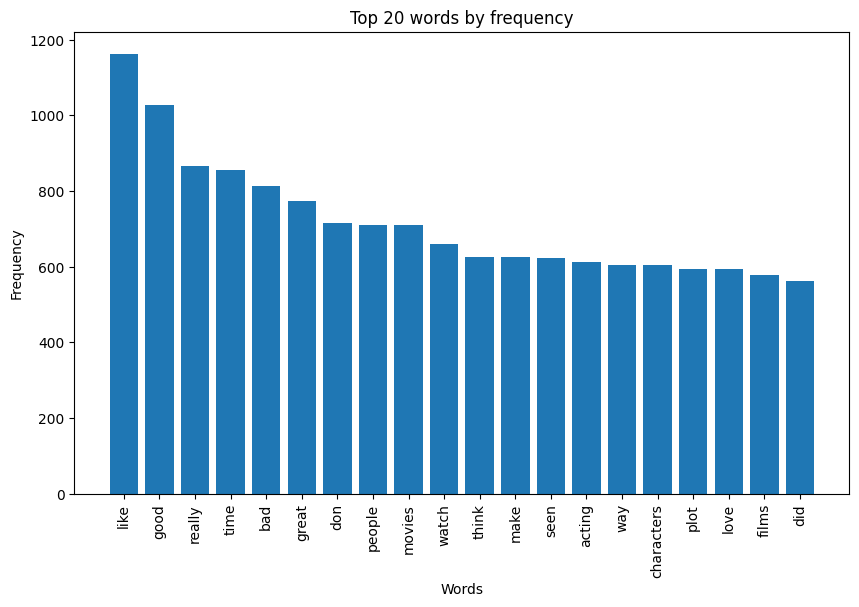

In [13]:
# Plot the distribution of words
word_counts = X_train_tfidf.sum(axis=0).A1
unique_words = vectorizer.get_feature_names_out()  # Define unique_words here
word_freq = dict(zip(unique_words, word_counts))
word_freq_sorted = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(10, 6))
plt.bar(*zip(*word_freq_sorted[:20]))
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 words by frequency')
plt.show()

# **COORDINATE FORMAT CONVERSION**

In [14]:
# Convert to COO format for graph construction
adj_train = X_train_tfidf.tocoo()
adj_test = X_test_tfidf.tocoo()
adj_twitter = X_twitter_tfidf.tocoo()

# **Sample of the COO format**

In [15]:
# Display a sample of the COO format
print("Sample of the COO format (train set):")
print(f"Row indices: {adj_train.row[:10]}")
print(f"Column indices: {adj_train.col[:10]}")
print(f"Data values: {adj_train.data[:10]}")
print("\nSample of the COO format (test set):")
print(f"Row indices: {adj_test.row[:10]}")
print(f"Column indices: {adj_test.col[:10]}")
print(f"Data values: {adj_test.data[:10]}")

Sample of the COO format (train set):
Row indices: [0 0 0 0 0 0 0 0 0 0]
Column indices: [2066 4628    2  482 3854 4714 3499 2879  119 3466]
Data values: [0.11228633 0.06467776 0.05217468 0.11208406 0.0743155  0.09620538
 0.10466605 0.10327874 0.07315132 0.10165941]

Sample of the COO format (test set):
Row indices: [0 0 0 0 0 0 0 0 0 0]
Column indices: [4953 4799 4547 4532 4525 4523 4461 4441 4401 4295]
Data values: [0.05784271 0.52369199 0.15266257 0.07172663 0.05825512 0.03736861
 0.28438388 0.1139259  0.1298069  0.0761755 ]


# **EDGE INDICES & ATTRIBUTES**

In [16]:
# Convert COO format to edge index and edge attributes for PyTorch Geometric
edge_index_train, edge_attr_train = from_scipy_sparse_matrix(adj_train)
edge_index_test, edge_attr_test = from_scipy_sparse_matrix(adj_test)
edge_index_twitter, edge_attr_twitter = from_scipy_sparse_matrix(adj_twitter)

# **Sample of the edge index and edge attributes**

In [17]:
# Display a sample of the edge index and edge attributes
print("Sample of edge index (train set):")
print(edge_index_train[:, :10])  
print("Sample of edge attributes (train set):")
print(edge_attr_train[:10])  

print("\nSample of edge index (test set):")
print(edge_index_test[:, :10]) 
print("Sample of edge attributes (test set):")
print(edge_attr_test[:10]) 

Sample of edge index (train set):
tensor([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [2066, 4628,    2,  482, 3854, 4714, 3499, 2879,  119, 3466]])
Sample of edge attributes (train set):
tensor([0.1123, 0.0647, 0.0522, 0.1121, 0.0743, 0.0962, 0.1047, 0.1033, 0.0732,
        0.1017], dtype=torch.float64)

Sample of edge index (test set):
tensor([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [4953, 4799, 4547, 4532, 4525, 4523, 4461, 4441, 4401, 4295]])
Sample of edge attributes (test set):
tensor([0.0578, 0.5237, 0.1527, 0.0717, 0.0583, 0.0374, 0.2844, 0.1139, 0.1298,
        0.0762], dtype=torch.float64)


# **TENSOR FORMAT CONVERSION**

In [18]:
# Convert to tensor format
x_train = torch.tensor(adj_train.toarray(), dtype=torch.float).to(device)
x_test = torch.tensor(adj_test.toarray(), dtype=torch.float).to(device)
x_twitter = torch.tensor(adj_twitter.toarray(), dtype=torch.float).to(device)

# **Sample**

In [19]:
# Print sample tensors
print("Sample tensor from IMDB train data:")
print(x_train[:1])  # Print the first tensor

print("\nSample tensor from Twitter data:")
print(x_twitter[:1])  # Print the first tensor

Sample tensor from IMDB train data:
tensor([[0.0000, 0.0000, 0.0522,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')

Sample tensor from Twitter data:
tensor([[0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')


# **CREATING PYTORCH GEOMETRIC**

In [20]:
# Create PyTorch Geometric data objects
train_data = Data(x=x_train, edge_index=edge_index_train, edge_attr=edge_attr_train, y=torch.tensor(y_train.values, dtype=torch.long).to(device))
test_data = Data(x=x_test, edge_index=edge_index_test, edge_attr=edge_attr_test, y=torch.tensor(y_test.values, dtype=torch.long).to(device))
test_data_twitter = Data(x=x_twitter, edge_index=edge_index_twitter, edge_attr=edge_attr_twitter, y=torch.tensor(y_twitter_adjusted.values, dtype=torch.long).to(device))

# **Sample of the train & test**

In [21]:
#Train Data
print("Train data sample:")
print("x_train (features):")
print(x_train[:5])  
print("edge_index_train:")
print(edge_index_train[:, :10]) 
print("edge_attr_train:")
print(edge_attr_train[:10])  
print("y_train (labels):")
print(train_data.y[:5]) 

# Test Data
print("\nTest data sample:")
print("x_test (features):")
print(x_test[:5])  
print("edge_index_test:")
print(edge_index_test[:, :10])  
print("edge_attr_test:")
print(edge_attr_test[:10])  
print("y_test (labels):")
print(test_data.y[:5]) 

Train data sample:
x_train (features):
tensor([[0.0000, 0.0000, 0.0522,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1243, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')
edge_index_train:
tensor([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [2066, 4628,    2,  482, 3854, 4714, 3499, 2879,  119, 3466]])
edge_attr_train:
tensor([0.1123, 0.0647, 0.0522, 0.1121, 0.0743, 0.0962, 0.1047, 0.1033, 0.0732,
        0.1017], dtype=torch.float64)
y_train (labels):
tensor([0, 0, 1, 0, 0], device='cuda:0')

Test data sample:
x_test (features):
tensor([[0.0000, 0.0000, 0.0545,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 

# **GNN MODEL**

In [22]:
# Define the GNN model
class GNN(nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(5000, 128)
        self.conv2 = GCNConv(128, 2)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# **TRAIN THE MODEL**

In [23]:
def train_model(train_data, params, patience=10, verbose=True):
    model = GNN().to(device)  # Move model to device
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
    
    # Ensure train_data is on the same device
    train_data = train_data.to(device)

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(params['epochs']):
        model.train()
        optimizer.zero_grad()
        
        out = model(train_data)  # Forward pass
        loss = F.nll_loss(out, train_data.y.to(device))  # Ensure target is on the device
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        train_accuracy = (out.argmax(dim=1) == train_data.y.to(device)).float().mean().item()
        train_accuracies.append(train_accuracy)

        # Optionally evaluate on the test data here if needed
        model.eval()
        with torch.no_grad():
            test_out = model(test_data.to(device))  # Move test data to device
            test_loss = F.nll_loss(test_out, test_data.y.to(device))
            test_losses.append(test_loss.item())
            test_accuracy = (test_out.argmax(dim=1) == test_data.y.to(device)).float().mean().item()
            test_accuracies.append(test_accuracy)

        if verbose:
            print(f'Epoch {epoch + 1}/{params["epochs"]}, Loss: {loss.item()}, Train Accuracy: {train_accuracy}, Test Loss: {test_loss.item()}, Test Accuracy: {test_accuracy}')

    return model, train_losses, test_losses, train_accuracies, test_accuracies


# **EVALUATE THE MODEL**

In [24]:
def evaluate_model(model, test_data):
    model.eval()
    with torch.no_grad():
        out = model(test_data)
        loss = F.nll_loss(out, test_data.y.to(device)).item()    

        # Get the predicted classes
        _, pred = out.max(dim=1)

        # Move tensors to CPU for metric calculations
        y_true = test_data.y.cpu()
        y_pred = pred.cpu()

        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    return accuracy, precision, recall, f1

# **HYPER PARAMETER TUNING**

In [25]:
# Assuming you have defined your model already
model = GNN().to(device)  # Create the model instance
best_params = None
best_score = 0
param_grid = {
    'lr': [0.01, 0.001, 0.0001],
    'weight_decay': [0, 1e-4, 1e-5],
    'epochs': [50, 100]
}

# Move train_data and test_data to the same device as the model
train_data = train_data.to(device)
test_data = test_data.to(device)

for lr in param_grid['lr']:
    for weight_decay in param_grid['weight_decay']:
        for epochs in param_grid['epochs']:
            print(f'Tuning parameters: lr={lr}, weight_decay={weight_decay}, epochs={epochs}')
            params = {'lr': lr, 'weight_decay': weight_decay, 'epochs': epochs}
            
            # Create a new model instance and optimizer for each parameter set
            model = GNN().to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

            train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

            for epoch in range(params['epochs']):
                optimizer.zero_grad()
                out = model(train_data)  # Forward pass
                loss = F.nll_loss(out, train_data.y)  # Calculate loss
                loss.backward()  # Backward pass
                optimizer.step()  # Update weights

                # Calculate training accuracy
                _, train_pred = out.max(dim=1)
                train_accuracy = accuracy_score(train_data.y.cpu(), train_pred.cpu())

                # Evaluate on test data
                test_out = model(test_data)
                test_loss = F.nll_loss(test_out, test_data.y).item()
                _, test_pred = test_out.max(dim=1)
                test_accuracy = accuracy_score(test_data.y.cpu(), test_pred.cpu())

                # Store losses and accuracies for plotting later
                train_losses.append(loss.item())
                test_losses.append(test_loss)
                train_accuracies.append(train_accuracy)
                test_accuracies.append(test_accuracy)

                # Print formatted results for training and testing
                print(f'Epoch {epoch + 1}/{params["epochs"]}, '
                      f'Loss: {loss.item():.3f}, Train Accuracy: {train_accuracy:.3f}, '
                      f'Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}')

            # Evaluate the model after training
            accuracy, precision, recall, f1 = evaluate_model(model, test_data)

            if accuracy > best_score:
                best_score = accuracy
                best_params = params
                # Save the best model
                joblib.dump(model.state_dict(), 'best_model.pkl')
                print(f'Best score: {best_score:.3f}, Best parameters: {best_params}')


Tuning parameters: lr=0.01, weight_decay=0, epochs=50
Epoch 1/50, Loss: 0.693, Train Accuracy: 0.505, Test Loss: 0.857, Test Accuracy: 0.574
Epoch 2/50, Loss: 0.846, Train Accuracy: 0.634, Test Loss: 0.986, Test Accuracy: 0.503
Epoch 3/50, Loss: 0.944, Train Accuracy: 0.517, Test Loss: 0.707, Test Accuracy: 0.496
Epoch 4/50, Loss: 0.714, Train Accuracy: 0.502, Test Loss: 0.691, Test Accuracy: 0.496
Epoch 5/50, Loss: 0.690, Train Accuracy: 0.501, Test Loss: 0.693, Test Accuracy: 0.496
Epoch 6/50, Loss: 0.692, Train Accuracy: 0.501, Test Loss: 0.693, Test Accuracy: 0.496
Epoch 7/50, Loss: 0.693, Train Accuracy: 0.501, Test Loss: 0.693, Test Accuracy: 0.496
Epoch 8/50, Loss: 0.693, Train Accuracy: 0.501, Test Loss: 0.693, Test Accuracy: 0.496
Epoch 9/50, Loss: 0.693, Train Accuracy: 0.501, Test Loss: 0.693, Test Accuracy: 0.507
Epoch 10/50, Loss: 0.693, Train Accuracy: 0.509, Test Loss: 0.693, Test Accuracy: 0.504
Epoch 11/50, Loss: 0.693, Train Accuracy: 0.499, Test Loss: 0.693, Test Acc

In [26]:
# Ensure labels in the Twitter dataset are within valid range
n_classes = 3  # Number of classes in the model output
test_data_twitter.y = torch.clamp(test_data_twitter.y, 0, n_classes - 1)

# **LOAD THE TUNED MODEL**

In [27]:
# Load the best model for final evaluation
best_model = GNN().to(device)
best_model.load_state_dict(joblib.load('best_model.pkl'))

<All keys matched successfully>

In [28]:
# Evaluate the best model on the Twitter dataset
test_data_twitter = test_data_twitter.to(device)  # Ensure test data is on the same device
twitter_accuracy, _, _, _ = evaluate_model(best_model, test_data_twitter)

# Print final evaluation results
print(f'Final Twitter Set - Accuracy: {twitter_accuracy:.4f}')

Final Twitter Set - Accuracy: 0.5571


# **CONFUSION MATRIX**

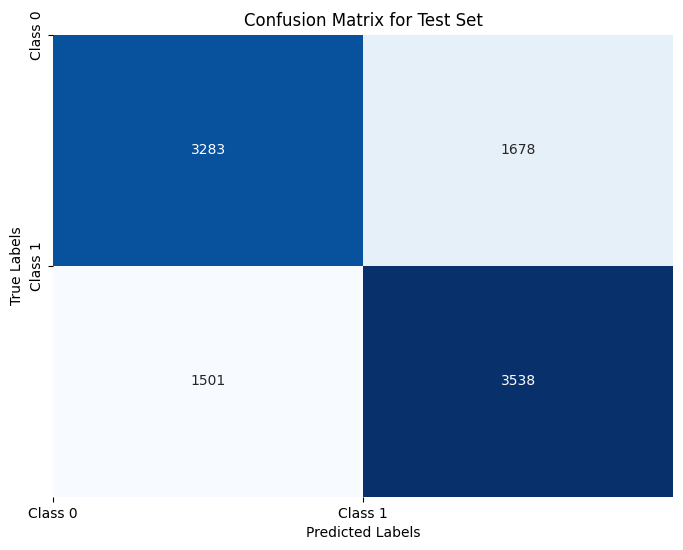

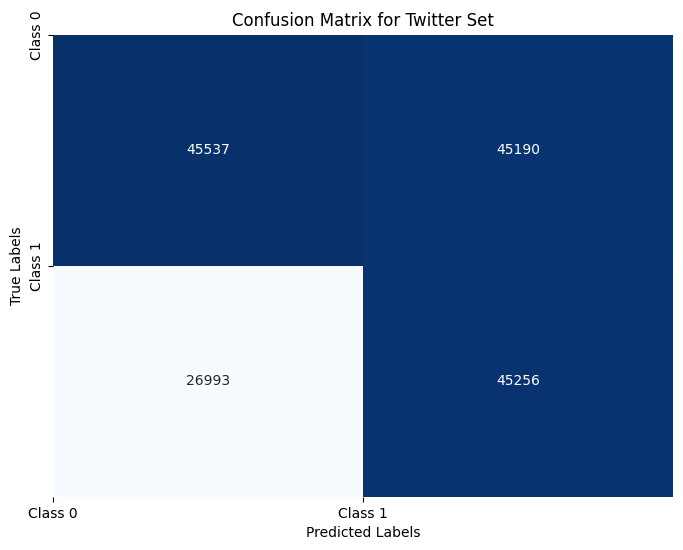

In [29]:
# Plot confusion matrices with counts
def plot_confusion_matrix(data, model, title):
    model.eval()
    data = data.to(device)  # Ensure data is on the same device
    with torch.no_grad():
        out = model(data)
        _, pred = out.max(dim=1)
        cm = confusion_matrix(data.y.cpu(), pred.cpu())
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(title)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        
        # Add class labels to axes
        class_labels = [f'Class {i}' for i in range(cm.shape[0])]
        plt.xticks(ticks=range(len(class_labels)), labels=class_labels)
        plt.yticks(ticks=range(len(class_labels)), labels=class_labels)

        plt.show()

# Plot confusion matrices for test and Twitter datasets
plot_confusion_matrix(test_data, best_model, 'Confusion Matrix for Test Set')
plot_confusion_matrix(test_data_twitter, best_model, 'Confusion Matrix for Twitter Set')


# **ACCURACY GRAPHS**

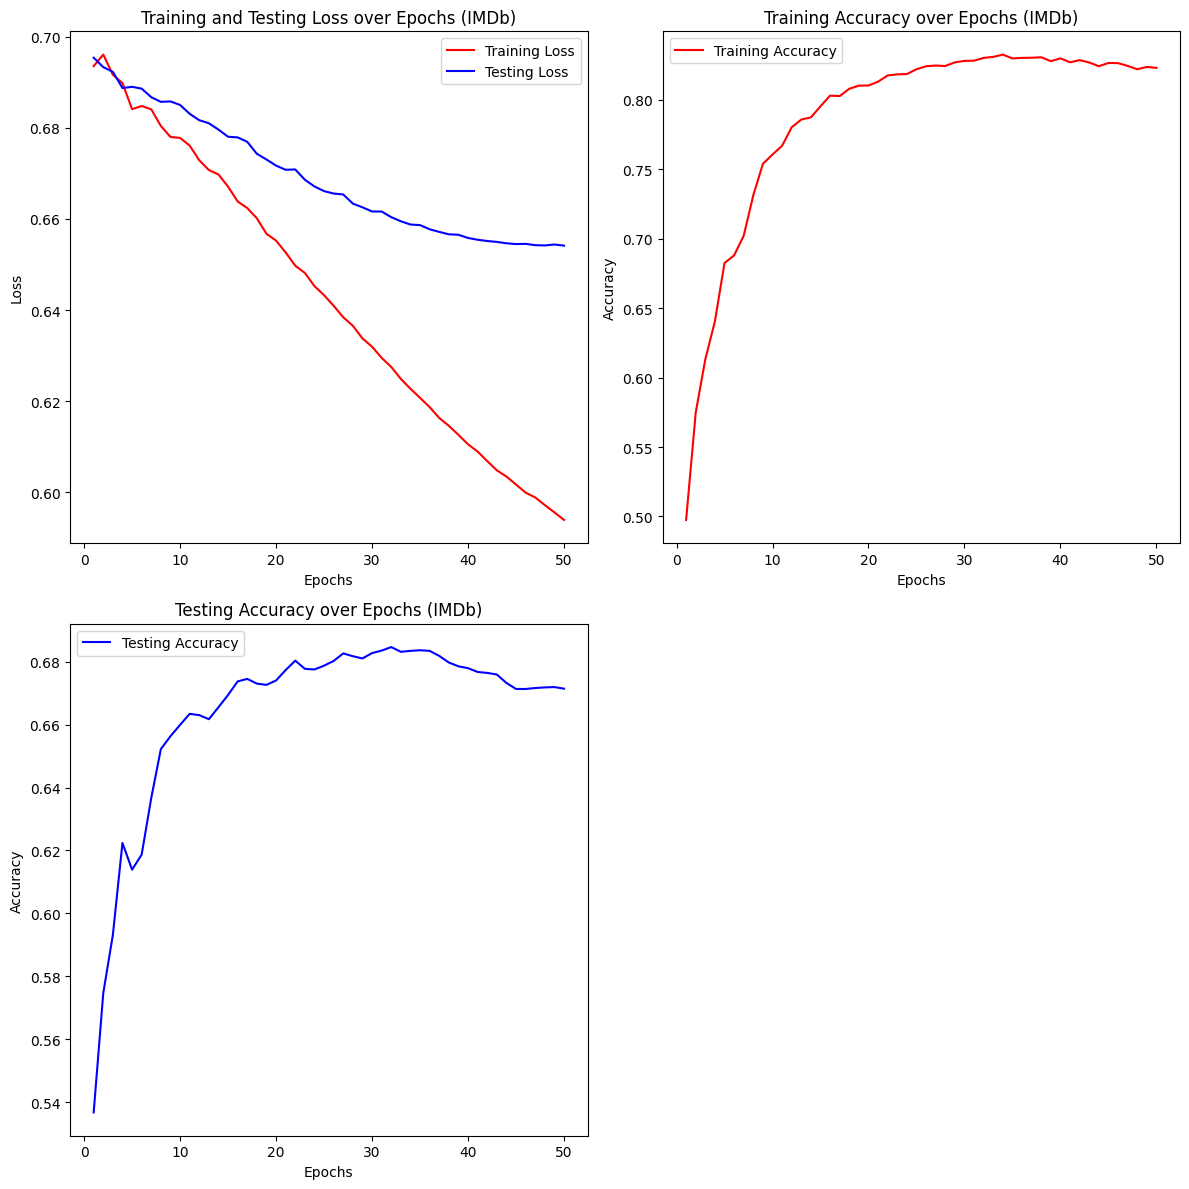

In [30]:
# Train the final model with best parameters
model_imdb, train_losses_imdb, test_losses_imdb, train_accuracies_imdb, test_accuracies_imdb = train_model(train_data, best_params, verbose=False)

# Plot the training and testing loss and accuracy
epochs = range(1, len(train_losses_imdb) + 1)

plt.figure(figsize=(12, 12))

# Plot Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses_imdb, label='Training Loss', color='red')
plt.plot(epochs, test_losses_imdb, label='Testing Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss over Epochs (IMDb)')
plt.legend()

# Plot Training Accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies_imdb, label='Training Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs (IMDb)')
plt.legend()

# Plot Testing Accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, test_accuracies_imdb, label='Testing Accuracy', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Testing Accuracy over Epochs (IMDb)')
plt.legend()

plt.tight_layout()
plt.show()

# **EVALUATION METRICS**

In [31]:
# Ensure the Twitter test data is on the same device
test_data_twitter = test_data_twitter.to(device)

# Evaluate the IMDb trained model on Twitter test data
print("Evaluating the IMDb trained model on Twitter test data")
accuracy_twitter, precision_twitter, recall_twitter, f1_twitter = evaluate_model(best_model, test_data_twitter)

# Print evaluation results
print(f'Accuracy on Twitter test data: {accuracy_twitter:.4f}')
print(f'Precision on Twitter test data: {precision_twitter:.4f}')
print(f'Recall on Twitter test data: {recall_twitter:.4f}')
print(f'F1 Score on Twitter test data: {f1_twitter:.4f}')

Evaluating the IMDb trained model on Twitter test data
Accuracy on Twitter test data: 0.5571
Precision on Twitter test data: 0.5713
Recall on Twitter test data: 0.5571
F1 Score on Twitter test data: 0.5572


# **ADDING NODE & EDGES TO GRAPH**

In [32]:
# Functions for adding node and edge attributes to a graph
def add_node_attributes(graph, node_id, word, label, classification):
    graph.add_node(node_id, 
                   feature=label, 
                   label=word,     
                   classification=classification)

def add_edge_attributes(graph, edge_index, edge_id):
    src = edge_index[0, edge_id]
    dst = edge_index[1, edge_id]
    edge_type = 'undirected'
    edge_label = 'Edge Label'
    interval = (0, 0)
    weight = 1.0
    graph.add_edge(src, dst,
                   type=edge_type,
                   id=str(edge_id),
                   label=edge_label,
                   Interval=str(interval),
                   weight=str(weight))

# **SAMPLE GRAPH**

In [33]:
# Function to sample a graph from data
def sample_graph(data, edge_index, num_samples, words, labels):
    valid_node_ids = np.arange(len(words))
    sampled_nodes = np.random.choice(valid_node_ids, num_samples, replace=False)
    G = nx.Graph()
    for node_id in sampled_nodes:
        review_label = labels[node_id % len(labels)]
        classification = 'positive' if review_label == 2 else 'negative'
        add_node_attributes(G, node_id, words[node_id], review_label, classification)
    for edge_id in range(edge_index.shape[1]):
        src = edge_index[0, edge_id]
        dst = edge_index[1, edge_id]
        if src in sampled_nodes and dst in sampled_nodes:
            add_edge_attributes(G, edge_index, edge_id)
    return G

In [34]:
# Define words and labels for graph sampling
train_labels = y_train.reset_index(drop=True)
test_labels = y_twitter_adjusted.reset_index(drop=True)
train_words = vectorizer.get_feature_names_out()
test_words = vectorizer.get_feature_names_out()

#  **GENERATING .GEXF FILE**

In [35]:
# Sample graphs for IMDb train and Twitter test data
num_samples = 250
# Move edge_index to CPU before converting to NumPy
G_train_sampled = sample_graph(train_data, train_data.edge_index.cpu().numpy(), num_samples, train_words, train_labels)
nx.write_gexf(G_train_sampled, "graph_imdb_train_sampled.gexf")

# Move edge_index to CPU for the Twitter test data as well
G_test_sampled = sample_graph(test_data_twitter, test_data_twitter.edge_index.cpu().numpy(), num_samples, test_words, test_labels)
nx.write_gexf(G_test_sampled, "graph_twitter_test_sampled.gexf")


# **USER INPUT TO CLASSIFY THE INPUT**

In [37]:
def classify_text(model, vectorizer, text):
    model.eval()
    with torch.no_grad():
        # Transform the input text using the vectorizer
        text_tfidf = vectorizer.transform([text])
        text_coo = text_tfidf.tocoo()
        edge_index, edge_attr = from_scipy_sparse_matrix(text_coo)

        # Convert the sparse matrix to a tensor
        x = torch.tensor(text_coo.toarray(), dtype=torch.float)

        # Check and create dummy edges if necessary
        if edge_index.shape[1] == 0 or edge_index.max() >= x.size(0):
            print(".")
            edge_index = torch.tensor([[0], [0]], dtype=torch.long)  # Self-loop for single node

        # Create the data object
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

        # Move data to the same device as the model
        data.x = data.x.to(next(model.parameters()).device)
        data.edge_index = data.edge_index.to(next(model.parameters()).device)
        if edge_attr is not None:
            data.edge_attr = data.edge_attr.to(next(model.parameters()).device)

        # Forward pass through the model
        out = model(data)
        _, pred = out.max(dim=1)
        return pred.item()

#Classify user input
while True:
    user_input = input("Please enter the text you want to classify (or type 'exit' to quit): ")
    if user_input.lower() == 'exit': 
        print("Exiting the classification tool.")
        break  # Exit the loop
    
    predicted_class = classify_text(model_imdb, vectorizer, user_input)
    class_labels = {0: 'Negative', 1: 'Positive'}  # Adjust according to your training labels
    print(f'The predicted class for the input text is: {class_labels[predicted_class]}')

Please enter the text you want to classify (or type 'exit' to quit):  Mr & MRS Mahi movie was a good movie


.
The predicted class for the input text is: Positive


Please enter the text you want to classify (or type 'exit' to quit):  Gautam Gambhir has seen same amount of ties in 4 games what Dravid saw in 160 games  Tie Games for India Coaches in international cricket  Rahul Dravid - 160 matches, 2 ties Gautam Gambhir - 4 matches, 2 ties


.
The predicted class for the input text is: Positive


Please enter the text you want to classify (or type 'exit' to quit):  Hridayam translates as “Heart” – Though it’s a simple title but sometimes they say Simple is more powerful, I guess that’s what has worked for this magical masterpiece on screen.  This is a romantic coming of age story of Arun Neelakandan (beautifully essayed by Pranav Mohanlal) and how his life transpires through various People he meets, incidents that happened in his life and off course his love interest shape him as a person. Ok I know it’s a regular coming of age story we have seen in so many movies of similar genre, that’s easy and said but Director Vineeth Sreenivasan makes sure he delivers his mark in this soulful tale that unfolds on big screen leaves all your emotions turned.    This close to 3 hours long movie might sound like a long affair to sit and watch but a quirky and engaging screenplay makes sure mostly you don’t get that thought.  Performances – All three leads deliver what’s exactly needed for the

.
The predicted class for the input text is: Positive


Please enter the text you want to classify (or type 'exit' to quit):  What the heck is going on with some of these reviews and reviewers, seriously. If you’re confused as to what you’re leaving a review for, you shouldn’t leave one. Anyhow, madame web must have been written by a 6 year old child. The narrative of the story doesn’t make sense, the sequence, NONE IF IT WORKS!. Just driving around in a stolen cab around town and to the airport, the sudden trip to Peru. And the perfect timing of her return to fend off the bad guy, it’s just so so bad. It’s really unbelievable how bad the writing really is, and then the cringey acting on top of it all is just so disappointing.  Hopefully all the criticism will help those who need the change in Hollywood. Because this movie is TRASH! It will go down as the worst superhero movie of all time. Absolutely disgraceful.   ***This is the perfect review: *** ***After reading other reviews, I’m convinced more than ever that there are a ton of shills 

.
The predicted class for the input text is: Negative


Please enter the text you want to classify (or type 'exit' to quit):  Awesome UPK. Well crafted drama. All the artistes are excellently fitted. Clean, wholesome, family series. Everyone is acting to their best. Kudos to the Director. Hats off to the story writer. Waiting for Thursdays !!!


.
The predicted class for the input text is: Positive


Please enter the text you want to classify (or type 'exit' to quit):  exit


Exiting the classification tool.
